In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
import pandas as pd
import numpy as np
import pickle
import joblib
from glob import glob
import os
from importlib.machinery import SourceFileLoader

In [3]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [5]:
fun = SourceFileLoader( 'funciones', r'..\..\..\code\modules\funciones.py' ).load_module()
vn  = SourceFileLoader( 'variables_nombres', r'..\..\..\code\modules\variables_nombres.py' ).load_module()

## 2. Cargar datos y hacer el split

In [6]:
path = r'..\..\..\input\preprocessed_data\base0_siaf.csv'
data = pd.read_csv( path )

In [7]:
dep_var    = [ 'corrup_intensa' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio', 
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_amplia',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ], 
                                                     data[ 'corrup_intensa' ], 
                                                     test_size    = 0.3,
                                                     random_state = 2023 )

## 3. Calcular las métricas con los distintos modelos

In [10]:
path      = r'..\..\..\output\ejecucion_6\models\base0\*.joblib'
path_list = glob( path )
models    = []
columns   = [ 'no', 'si' ]
results   = {

    'Model'      : [],
    'f1_train_si': [],
    'f1_train_no': [],
    'f1_test_si' : [],
    'f1_test_no' : [],
}

for i, model in enumerate( path_list ):  
    
    loaded_model       = joblib.load( model )
    filename           = os.path.basename( model )
    y_pred_train_class = loaded_model.predict( x_train )
    y_pred_test_class  = loaded_model.predict( x_test )
    
    report_train       = classification_report( y_train, y_pred_train_class, target_names = columns, output_dict = True )
    report_test        = classification_report( y_test, y_pred_test_class, target_names = columns, output_dict = True )
    
    f1_score_train_si  = report_train[ 'si' ][ 'f1-score' ]
    f1_score_train_no  = report_train[ 'no' ][ 'f1-score' ]
    f1_score_test_si   = report_test[ 'si' ][ 'f1-score' ]
    f1_score_test_no   = report_test[ 'no' ][ 'f1-score' ]
    
    results[ 'Model' ].append( filename )    
    results[ 'f1_train_si' ].append( round( f1_score_train_si, 3 ) )
    results[ 'f1_train_no' ].append( round( f1_score_train_no, 3 ) )
    results[ 'f1_test_si' ].append( round( f1_score_test_si, 3 ) )
    results[ 'f1_test_no' ].append( round( f1_score_test_no, 3 ) )      
    
results_df = pd.DataFrame( results )
results_df = results_df.sort_values( by = 'f1_test_si', ascending = False )

[14:30:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:30:40] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:30:42] WARNING: C:\Users\dev-admin

In [11]:
results_df.to_excel( r'..\..\..\output\ejecucion_6\results\base0\base0_ci_other_metrics.xlsx' )

## 4. Shap plot

In [17]:
import shap
shap.initjs()

path         = r'..\..\..\output\ejecucion_5\models\base0\model_ci_Random Forest Classifier_3.joblib'
loaded_model = joblib.load( path )

In [18]:
loaded_model

RandomForestClassifier(max_depth=30, max_features=5808, n_estimators=250,
                       n_jobs=-1, random_state=2023)

In [20]:
x_train_s, x_train_st, x_train_nro, y_train_s, y_train_st, y_train_nro = fun.resampling( x_train, y_train )

In [22]:
explainer   = shap.Explainer( loaded_model )
shap_values = explainer( x_train_nro )
np.shape( shap_values.values )

(1366, 14520, 2)

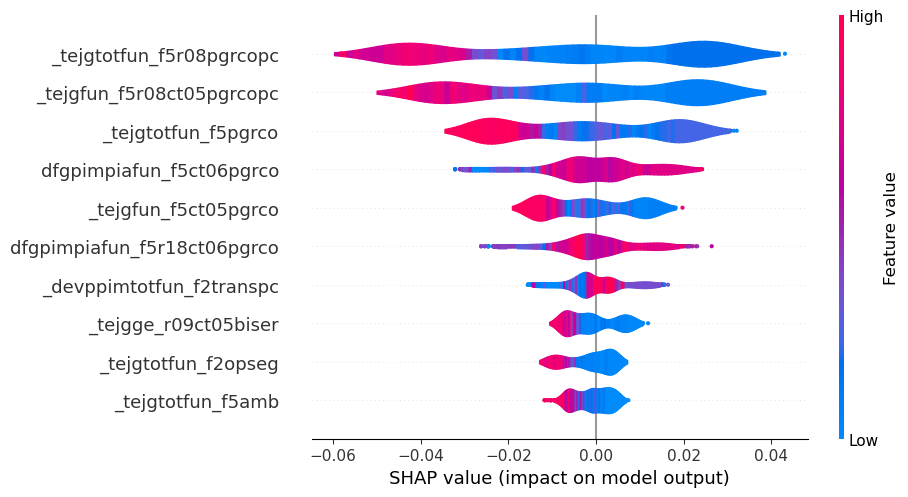

In [29]:
shap.plots.violin(shap_values[:,:,1], max_display = 10 )

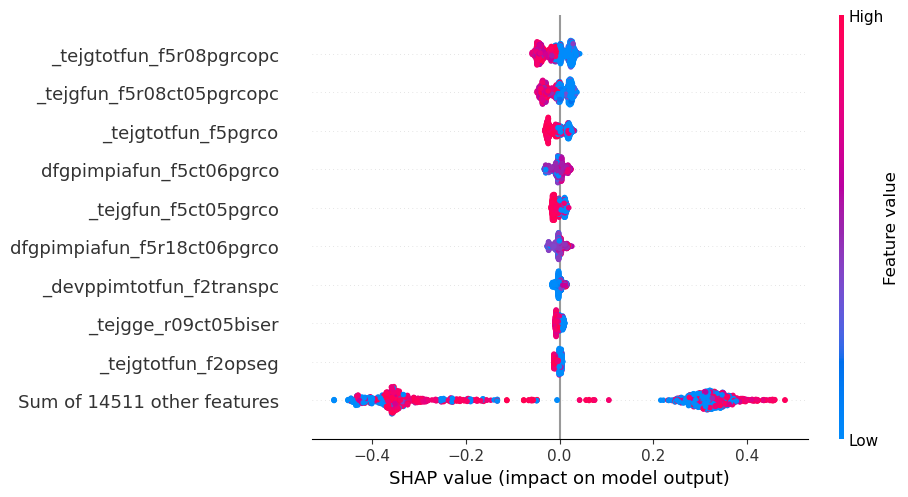

In [30]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 10 )